In [1]:
!pip install pandas
!pip install sklearn
!pip install matplotlib
!pip install seaborn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=2397 sha256=5a0176fed1f3d9d4f48f3b10593c575f17838dbc0c48a38d7b0e2bda39a60adc
  Stored in directory: /root/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [136]:
import tensorflow as tf
tf.__version__

'2.0.0-rc0'

In [143]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
%matplotlib inline

In [47]:
raw_df = pd.read_csv("./PRSA_data_2010.1.1-2014.12.31.csv")

In [48]:
raw_df = raw_df.iloc[:,5:]

In [49]:
raw_df.shape

(43824, 8)

In [50]:
raw_df.iloc[:,0].isna().sum()

2067

In [51]:
43824-2067

41757

In [52]:
raw_df.describe()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [53]:
raw_df=raw_df.dropna();raw_df

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,129.0,-16,-4.0,1020.0,SE,1.79,0,0
25,148.0,-15,-4.0,1020.0,SE,2.68,0,0
26,159.0,-11,-5.0,1021.0,SE,3.57,0,0
27,181.0,-7,-5.0,1022.0,SE,5.36,1,0
28,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
43819,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [54]:
raw_df=raw_df.drop("cbwd",axis=1)

In [58]:
raw_df

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
24,129.0,-16,-4.0,1020.0,1.79,0,0
25,148.0,-15,-4.0,1020.0,2.68,0,0
26,159.0,-11,-5.0,1021.0,3.57,0,0
27,181.0,-7,-5.0,1022.0,5.36,1,0
28,138.0,-7,-5.0,1022.0,6.25,2,0
...,...,...,...,...,...,...,...
43819,8.0,-23,-2.0,1034.0,231.97,0,0
43820,10.0,-22,-3.0,1034.0,237.78,0,0
43821,10.0,-22,-3.0,1034.0,242.70,0,0
43822,8.0,-22,-4.0,1034.0,246.72,0,0


In [59]:
variables = raw_df.iloc[:,1:].values

In [60]:
variables.shape

(41757, 6)

In [61]:
target = raw_df.iloc[:,0].values

In [66]:
target=target.reshape(-1,1)

In [68]:
target.shape

(41757, 1)

In [75]:
cv_split = 30000
test_split = 35000

In [123]:
X_train = variables[:cv_split,:]
y_train = target[:cv_split,:]

X_cv = variables[cv_split:test_split,:]
y_cv = target[cv_split:test_split,:]

X_test = variables[test_split:,:]
y_test = target[test_split:,:]

In [124]:
assert X_train.shape[0]==y_train.shape[0]
assert X_cv.shape[0]==y_cv.shape[0]
assert X_test.shape[0]==y_test.shape[0]

In [173]:
normalizer = MinMaxScaler(feature_range = (0, 1))


X_train_n = normalizer.fit_transform(X_train)
y_train_n = normalizer.fit_transform(y_train)

X_cv_n = normalizer.fit_transform(X_cv)
y_cv_n = normalizer.fit_transform(y_cv)

X_test_n = normalizer.fit_transform(X_test)
y_test_n = normalizer.fit_transform(y_test)

In [174]:
X_train_windowed = []
y_train_windowed = []
window_len = 10
#ToDo: Add previous Targets,PM2.5, as a predictor as well.
for i in range(window_len,cv_split):
    X_train_windowed.append(X_train_n[i-window_len:i,:])
    y_train_windowed.append(y_train_n[i])
X_train_windowed,y_train_windowed = np.array(X_train_windowed),np.array(y_train_windowed)
    

In [175]:
X_cv_windowed = []
y_cv_windowed = []
window_len = 10
#ToDo: Add previous Targets,PM2.5, as a predictor as well.
for i in range(window_len,X_cv_n.shape[0]):
    X_cv_windowed.append(X_cv_n[i-window_len:i,:])
    y_cv_windowed.append(y_cv_n[i])
X_cv_windowed,y_cv_windowed = np.array(X_cv_windowed),np.array(y_cv_windowed)
    

In [176]:
X_test_windowed = []
y_test_windowed = []
window_len = 10
#ToDo: Add previous Targets,PM2.5, as a predictor as well.
for i in range(window_len,X_test_n.shape[0]):
    X_test_windowed.append(X_test_n[i-window_len:i,:])
    y_test_windowed.append(y_test_n[i])
X_test_windowed,y_test_windowed = np.array(X_test_windowed),np.array(y_test_windowed)
    

In [177]:
y_train_windowed.shape

(29990, 1)

In [178]:
model = Sequential()
model.add(LSTM(200,return_sequences=True,input_shape=[window_len,6],activation='linear'))
model.add(LSTM(100,activation='linear'))
model.add(Dense(1))
model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', 
                  metrics = ['mean_absolute_error'])

model.fit(X_train_windowed, y_train_windowed, epochs = 10, batch_size = 64)


Train on 29990 samples
Epoch 1/10
29990/29990 [==============================] - 26s 851us/sample - loss: 0.0077 - mean_absolute_error: 0.0610
Epoch 2/10
29990/29990 [==============================] - 22s 747us/sample - loss: 0.0057 - mean_absolute_error: 0.0532
Epoch 3/10
29990/29990 [==============================] - 22s 748us/sample - loss: 0.0054 - mean_absolute_error: 0.0518
Epoch 4/10
29990/29990 [==============================] - 23s 766us/sample - loss: 0.0053 - mean_absolute_error: 0.0508
Epoch 5/10
29990/29990 [==============================] - 23s 783us/sample - loss: 0.0052 - mean_absolute_error: 0.0502
Epoch 6/10
29990/29990 [==============================] - 23s 776us/sample - loss: 0.0051 - mean_absolute_error: 0.0497
Epoch 7/10
29990/29990 [==============================] - 23s 767us/sample - loss: 0.0050 - mean_absolute_error: 0.0494
Epoch 8/10
29990/29990 [==============================] - 23s 763us/sample - loss: 0.0050 - mean_absolute_error: 0.0492
Epoch 9/10
29990/

In [179]:
cv_preds = model.predict(X_cv_windowed)

In [180]:
cv_preds


array([[0.11511995],
       [0.12256846],
       [0.11516738],
       ...,
       [0.05674716],
       [0.07291615],
       [0.08287352]], dtype=float32)

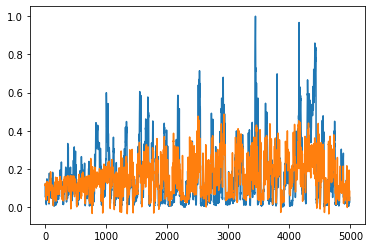

In [181]:
plt.plot(y_cv_windowed)
plt.plot(cv_preds)